In [1]:
import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from scipy.special import expit

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

# Creates Data

In [4]:
def DataGenerator(w, n = 20, m = 512):
    X = []
    Y = []
    for _ in range(m):
        x = np.random.randn(n)
        X.append(x)
        Y.append(np.random.binomial(1, p = expit(np.dot(x, w)), size = 1))
        
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, np.reshape(Y, [-1])

class LinearDataset(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(LinearDataset, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.LongTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [5]:
n = 20
w = np.random.randn(n)
X_train, Y_train = DataGenerator(w, n = n)
X_test, Y_test = DataGenerator(w, n = n)

In [6]:
print(X_train.shape, Y_train.shape)

(512, 20) (512,)


# Define Model

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim = 20, output_dim = 2, device = 'cpu'):
        super(LinearRegression, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(input_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        return self.linear(input)
        
    def proba(self, input):
        return F.softmax(self.linear(input), dim = -1)

# Model Trainer

In [8]:
class callback():
    def __init__(self, X_train, Y_train, X_test, Y_test, loss_function, device = 'cpu'):
        self.X_test_tr = torch.FloatTensor(X_test).to(device)
        self.X_train_tr = torch.FloatTensor(X_train).to(device)
        self.Y_train_tr = torch.LongTensor(Y_train).to(device)
        self.Y_test_tr = torch.LongTensor(Y_test).to(device)
        self.loss_function = loss_function
        
        self.step = 0
        self.list_of_train_loss = []
        self.list_of_test_loss = []
        
      
    def forward(self, model):
        model.eval()
        self.step += 1
        self.list_of_train_loss.append(loss_function(model(self.X_train_tr), self.Y_train_tr).cpu().data.numpy())
        self.list_of_test_loss.append(loss_function(model(self.X_test_tr), self.Y_test_tr).cpu().data.numpy())
        return
    
    def __call__(self, model):
        return self.forward(model)

In [9]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
        model.zero_grad()
        
        output = model(batch_of_x)
        loss = loss_function(output, batch_of_y)
        loss.backward()
        optimizer.step()
        
        return

In [10]:
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
    return

In [11]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None
           ):

    for it in tqdm(range(count_of_epoch)):
        optima = optimizer(model.parameters(), lr = lr)

        batch_generator = DataLoader(dataset = dataset, batch_size = batch_size)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima)
        
        if callback is not None:
            callback(model)
    
    return

# Define Model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [14]:
call = callback(X_train, Y_train, X_test, Y_test, loss_function, device)

In [15]:
model = LinearRegression(20, 2, device)

In [16]:
dataset = LinearDataset(X_train, Y_train, device = device)

In [17]:
trainer(count_of_epoch = 1000,
        batch_size = 64,
        dataset = dataset,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call,
       )

# Analize Model

In [18]:
X_test_tr = torch.FloatTensor(X_test).to(device)
X_train_tr = torch.FloatTensor(X_train).to(device)
Y_train_tr = torch.LongTensor(Y_train).to(device)
Y_test_tr = torch.LongTensor(Y_test).to(device)

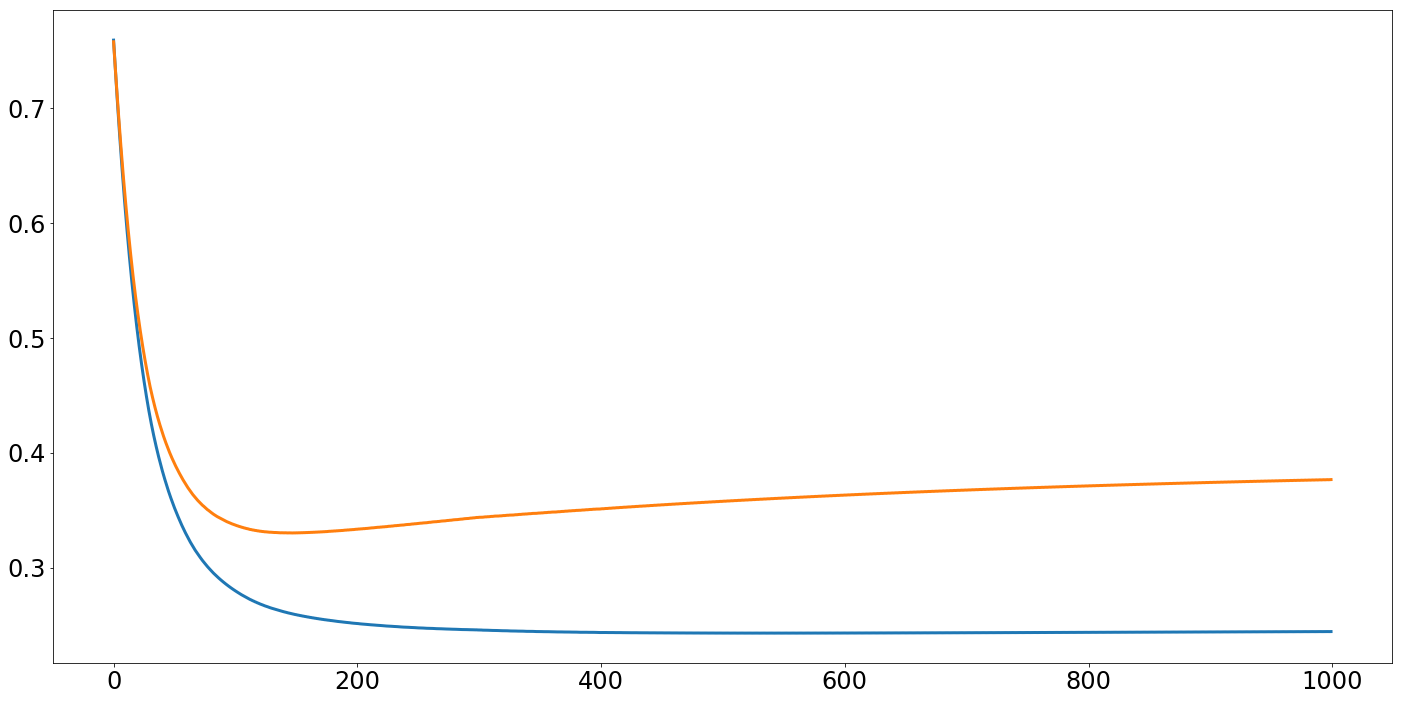

In [19]:
plt.plot(call.list_of_train_loss)
plt.plot(call.list_of_test_loss)

In [20]:
print(("Train acc = %f\n Test acc = %f")%
      ((np.argmax(model.proba(X_train_tr).cpu().data.numpy(), axis = 1) == Y_train).sum()/Y_train.shape[0], 
       (np.argmax(model.proba(X_test_tr).cpu().data.numpy(), axis = 1) == Y_test).sum()/Y_test.shape[0]))

Train acc = 0.904297
 Test acc = 0.845703
